In [11]:
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf

%matplotlib inline

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [2]:
import pathlib

data_dir = pathlib.Path('dataset')
print(os.listdir(data_dir))

['snow leopard', 'leopard', 'cheetah', 'jaguar']


In [3]:
# this should have 4000 files found, 1200 for validation...
IMAGE_SIZE = (150, 150)
BATCH_SIZE = 32

train_ds = keras.preprocessing.image_dataset_from_directory(
    'dataset',
    batch_size=BATCH_SIZE,
    seed=420,
    validation_split=0.3,
    subset='training',
    image_size=IMAGE_SIZE
)

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    'dataset',
    batch_size=BATCH_SIZE,
    seed=420,
    validation_split=0.3,
    subset='validation',
    image_size=IMAGE_SIZE
)

print(train_ds, val_ds)

Found 4000 files belonging to 4 classes.
Using 2800 files for training.
Found 4000 files belonging to 4 classes.
Using 1200 files for validation.
<BatchDataset shapes: ((None, 150, 150, 3), (None,)), types: (tf.float32, tf.int32)> <BatchDataset shapes: ((None, 150, 150, 3), (None,)), types: (tf.float32, tf.int32)>


In [4]:
for image_batch, labels_batch in train_ds:
    print(image_batch.shape)
    print(labels_batch.shape)
    break

(32, 150, 150, 3)
(32,)


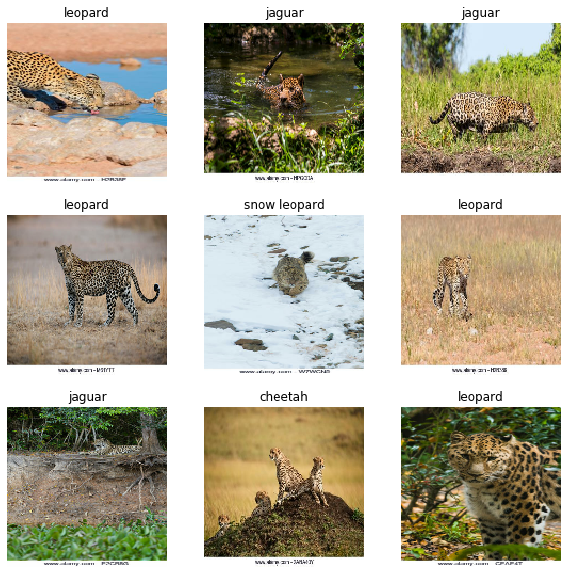

In [5]:
import matplotlib.pyplot as plt

class_names = train_ds.class_names

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [6]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [7]:
normalization_layer = layers.experimental.preprocessing.Rescaling(1./255)

In [9]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))

Start with a simple model.

In [14]:
num_classes = 4

model = keras.Sequential()

# add layers
model.add(layers.experimental.preprocessing.Rescaling(1./255, input_shape=(*IMAGE_SIZE, 3)))
model.add(layers.Conv2D(16, 3, padding='same', activation='relu'))
model.add(layers.MaxPooling2D())
model.add(layers.Dropout(0.2))
model.add(layers.Flatten(input_shape=IMAGE_SIZE))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(num_classes))

In [15]:
model.compile(optimizer='adam',
              loss="sparse_categorical_crossentropy",
              metrics=['accuracy'])

In [16]:
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=10
)

Epoch 1/10
88/88 [==============================] - 22s 246ms/step - loss: 8.7073 - accuracy: 0.2614 - val_loss: 8.8194 - val_accuracy: 0.2450
Epoch 2/10
88/88 [==============================] - 21s 242ms/step - loss: 9.0298 - accuracy: 0.2506 - val_loss: 8.8194 - val_accuracy: 0.2450
Epoch 3/10
88/88 [==============================] - 21s 240ms/step - loss: 8.6685 - accuracy: 0.2610 - val_loss: 8.8194 - val_accuracy: 0.2450
Epoch 4/10
88/88 [==============================] - 21s 243ms/step - loss: 8.6766 - accuracy: 0.2555 - val_loss: 8.8194 - val_accuracy: 0.2450
Epoch 5/10
88/88 [==============================] - 22s 248ms/step - loss: 9.0708 - accuracy: 0.2438 - val_loss: 8.8194 - val_accuracy: 0.2450
Epoch 6/10
88/88 [==============================] - 22s 245ms/step - loss: 8.6965 - accuracy: 0.2570 - val_loss: 8.8194 - val_accuracy: 0.2450
Epoch 7/10
88/88 [==============================] - 24s 278ms/step - loss: 8.8545 - accuracy: 0.2492 - val_loss: 8.8194 - val_accuracy: 0.2450

Let's analyze the results.

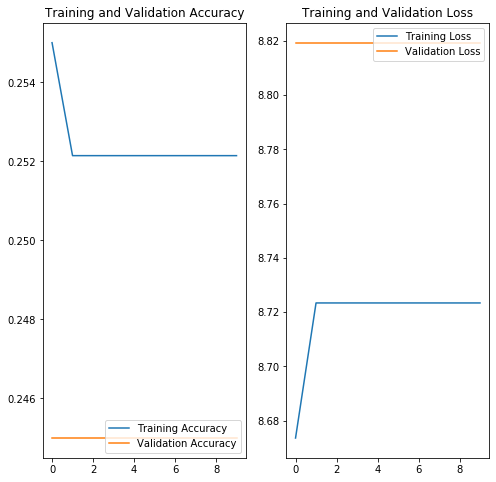

In [17]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss=history.history['loss']
val_loss=history.history['val_loss']

epochs_range = range(10)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

With the basic model, we could only achieve up to 60% and 50% accuracy for the training set and the validation set, respectively. Although the loss graph showed consistent decline, it did not correlate with increasing accuracy completely.

Let's try it with some convolutional layers added.

In [18]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling_3 (Rescaling)      (None, 150, 150, 3)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 150, 150, 16)      448       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 75, 75, 16)        0         
_________________________________________________________________
dropout (Dropout)            (None, 75, 75, 16)        0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 90000)             0         
_________________________________________________________________
dense_4 (Dense)              (None, 64)                5760064   
_________________________________________________________________
dense_5 (Dense)              (None, 4)                

In [21]:
# data augmentation
data_augmentation = keras.Sequential(
  [
    layers.experimental.preprocessing.RandomFlip("horizontal", 
                                                 input_shape=(*IMAGE_SIZE,
                                                              3)),
    layers.experimental.preprocessing.RandomRotation(0.1),
    layers.experimental.preprocessing.RandomZoom(0.1),
  ]
)

# make new model
model = Sequential([
    layers.experimental.preprocessing.Rescaling(1./255, input_shape=(*IMAGE_SIZE, 3)),
    data_augmentation,
    layers.Conv2D(16, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(32, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(64, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(num_classes)
])

In [22]:
model.compile(optimizer='adam',
              loss="sparse_categorical_crossentropy",
              metrics=['accuracy'])

In [23]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling_4 (Rescaling)      (None, 150, 150, 3)       0         
_________________________________________________________________
sequential_3 (Sequential)    (None, 150, 150, 3)       0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 150, 150, 16)      448       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 75, 75, 16)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 75, 75, 32)        4640      
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 37, 37, 32)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 37, 37, 64)       

References used:

1. https://www.tensorflow.org/tutorials/images/classification

In [24]:
history2 = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=10
)

Epoch 1/10
88/88 [==============================] - 50s 564ms/step - loss: 6.6345 - accuracy: 0.2495 - val_loss: 4.9804 - val_accuracy: 0.2550
Epoch 2/10
88/88 [==============================] - 48s 542ms/step - loss: 5.2167 - accuracy: 0.2423 - val_loss: 4.9804 - val_accuracy: 0.2550
Epoch 3/10
88/88 [==============================] - 48s 540ms/step - loss: 4.9626 - accuracy: 0.2511 - val_loss: 4.9804 - val_accuracy: 0.2550
Epoch 4/10
88/88 [==============================] - 48s 543ms/step - loss: 5.0026 - accuracy: 0.2548 - val_loss: 4.9804 - val_accuracy: 0.2550
Epoch 5/10
88/88 [==============================] - 48s 544ms/step - loss: 5.2090 - accuracy: 0.2523 - val_loss: 4.9804 - val_accuracy: 0.2550
Epoch 6/10
88/88 [==============================] - 49s 554ms/step - loss: 5.2715 - accuracy: 0.2444 - val_loss: 4.9804 - val_accuracy: 0.2550
Epoch 7/10
88/88 [==============================] - 57s 646ms/step - loss: 5.1312 - accuracy: 0.2452 - val_loss: 4.9804 - val_accuracy: 0.2550

Even with the convolutional layers added, the accuracy results do not fare much better, if not worse.

## With Resnet

Let's try applying transfer learning with ResNet architecture.

Reference code:

1. https://www.tensorflow.org/tutorials/images/transfer_learning
2. https://www.kaggle.com/suniliitb96/tutorial-keras-transfer-learning-with-resnet50
3. https://thedatafrog.com/en/articles/image-recognition-transfer-learning/
4. https://www.tensorflow.org/tutorials/keras/classification

In [3]:
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.python.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

In [4]:
IMAGE_SIZE = (160, 160)
BATCH_SIZE = 32

data_gen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    validation_split = 0.2
)

train_ds = data_gen.flow_from_directory(
    'dataset',
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    subset='training', 
)

val_ds = data_gen.flow_from_directory(
    'dataset',
    target_size=IMAGE_SIZE,
    batch_size = BATCH_SIZE,
    subset='validation'
)
   
print(train_ds, val_ds)

Found 3200 images belonging to 4 classes.
Found 800 images belonging to 4 classes.
<tensorflow.python.keras.preprocessing.image.DirectoryIterator object at 0x116a1b450> <tensorflow.python.keras.preprocessing.image.DirectoryIterator object at 0x11619c9d0>


In [5]:
NUM_CLASSES = 4

# make base model; it will be frozen
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(*IMAGE_SIZE, 3))
for layer in base_model.layers:
    layer.trainable = False
    
# put the trainable layers of the model
x = keras.layers.Flatten()(base_model.output)
x = keras.layers.Dense(64, activation='relu')(x)
x = keras.layers.Dense(32, activation='relu')(x)
x = keras.layers.Dense(16, activation='relu')(x)
prediction_layer = keras.layers.Dense(NUM_CLASSES, activation='softmax')(x)

model = keras.models.Model(inputs=base_model.input, outputs=prediction_layer)

In [6]:
model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 160, 160, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 166, 166, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 80, 80, 64)   9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 80, 80, 64)   256         conv1_conv[0][0]                 
_______________________________________________________________________________________

In [7]:
# PUT EARLY STOPPER(?)
model.compile(loss='categorical_crossentropy',
                  optimizer=keras.optimizers.Adamax(lr=0.001),
                  metrics=['accuracy'])

history = model.fit(
    train_ds,
    steps_per_epoch=50,
    validation_data=val_ds,
    epochs=5,
)

Epoch 1/5
50/50 [==============================] - 128s 3s/step - loss: 1.4591 - accuracy: 0.5688 - val_loss: 0.6758 - val_accuracy: 0.7738
Epoch 2/5
50/50 [==============================] - 124s 2s/step - loss: 0.3996 - accuracy: 0.8756 - val_loss: 0.5434 - val_accuracy: 0.8188
Epoch 3/5
50/50 [==============================] - 122s 2s/step - loss: 0.3406 - accuracy: 0.8807 - val_loss: 0.5646 - val_accuracy: 0.8438
Epoch 4/5
50/50 [==============================] - 122s 2s/step - loss: 0.2046 - accuracy: 0.9367 - val_loss: 0.4980 - val_accuracy: 0.8512
Epoch 5/5
50/50 [==============================] - 122s 2s/step - loss: 0.1417 - accuracy: 0.9604 - val_loss: 0.4916 - val_accuracy: 0.8462


In [8]:
# save model for later use
model_path = 'my_model'
model.save(model_path)

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: my_model/assets


In [9]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [11]:
legend = ['training', 'validation']

def plot_history(history, yrange=[0,1]):
    
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    # Get number of epochs
    epochs = np.array(range(len(acc))) + 1

    # Plot training and validation accuracy per epoch
    plt.figure(figsize=(8,6))
    plt.grid(True)
    
    plt.plot(epochs, acc)
    plt.plot(epochs, val_acc)
    plt.title('Training and validation accuracy')
    plt.xticks(epochs)
    plt.ylim(yrange)
    plt.legend(legend)
    
    # Plot training and validation loss per epoch
    plt.figure(figsize=(8,6))
    plt.grid(True)

    plt.plot(epochs, loss)
    plt.plot(epochs, val_loss)
    plt.title('Training and validation loss')
    plt.xticks(epochs)
    plt.legend(legend)
    
    plt.show()

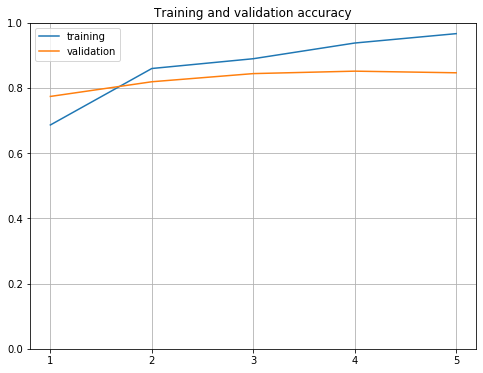

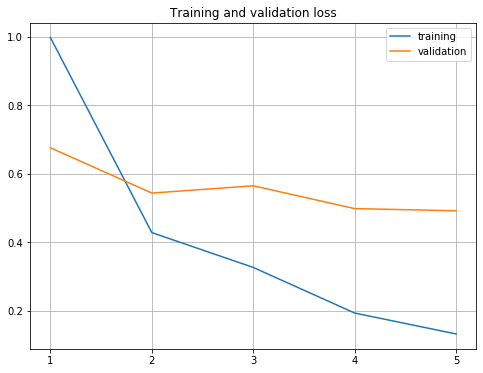

In [12]:
plot_history(history)

## Evaluate model

Model checkpoint #1. **Start here if you already have a model saved!**

In [5]:
model = keras.models.load_model('my_model')

In [6]:
model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 160, 160, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 166, 166, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 80, 80, 64)   9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 80, 80, 64)   256         conv1_conv[0][0]                 
_______________________________________________________________________________________

In [9]:
dir(val_ds)

['__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getitem__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__iter__',
 '__le__',
 '__len__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__next__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_filepaths',
 '_flow_index',
 '_get_batches_of_transformed_samples',
 '_keras_api_names',
 '_keras_api_names_v1',
 '_set_index_array',
 'allowed_class_modes',
 'batch_index',
 'batch_size',
 'class_indices',
 'class_mode',
 'classes',
 'color_mode',
 'data_format',
 'directory',
 'dtype',
 'filenames',
 'filepaths',
 'image_data_generator',
 'image_shape',
 'index_array',
 'index_generator',
 'interpolation',
 'labels',
 'lock',
 'n',
 'next',
 'num_classes',
 'on_epoch_end',
 'reset',
 'sample_weight',
 'samples',
 'save_format',
 'save_prefix',
 'save_to_dir',
 'see

Let's evaluate the first batch by getting their predicted labels vs. true labels.

In [7]:
len(val_ds[0][0])

32

In [8]:
def get_batch_preds(dataset, i):
    batch = dataset[i]
    batch_imgs = batch[0]
    batch_labels = batch[1]
    batch_preds = model.predict(batch_imgs)
    
    return batch_labels, batch_preds

In [9]:
# true labels, predicted labels
first_labels, first_preds = get_batch_preds(val_ds, 0)

In [10]:
# labels are in integers, so I used val_ds.filepaths to determine the label names
label_names = ['cheetah', 'jaguar', 'leopard', 'snow leopard']
label_names

['cheetah', 'jaguar', 'leopard', 'snow leopard']

In [40]:
# display batch for evaluation
# since each batch has 32 items, we will display 16 for visual purposes
def plot_batch(pred_arr, true_arr, img):
    idxs = np.arange(0, 32, 2)
    
    plt.figure(figsize=(16,16))
    
    for i in range(len(idxs)):
        x = i % 4
        y = i // 4
        
        #axarr[x,y].grid(False)
        #axarr[x,y].xticks([])
        #axarr[x,y].yticks([])
        #axarr[x,y].imshow(img[i])
        
        plt.subplot(4, 4, i+1)
        plt.grid(False)
        plt.xticks([])
        plt.yticks([])
        plt.imshow(img[i])
        
        pred_label = np.argmax(pred_arr[i])
        if pred_label == np.argmax(true_arr[i]):
            color = 'green'
        else:
            color = 'red'
        
        plt.xlabel('Pred: {} {:2.0f}%\nTrue: {}'.format(label_names[pred_label],
                                                             100*np.max(pred_arr[i]),
                                                             label_names[np.argmax(true_arr[i])]),
                         color=color)
        
    return

In [17]:
len(first_labels), len(first_preds)

(32, 32)

In [18]:
val_ds[0][0]

array([[[[  82.061    ,  104.221    ,  131.32     ],
         [  87.061    ,  105.221    ,  131.32     ],
         [  90.061    ,  106.221    ,  130.32     ],
         ...,
         [ 151.061    ,  138.22101  ,  131.32     ],
         [ 151.061    ,  138.22101  ,  131.32     ],
         [ 151.061    ,  138.22101  ,  131.32     ]],

        [[  82.061    ,  104.221    ,  131.32     ],
         [  87.061    ,  105.221    ,  131.32     ],
         [  90.061    ,  106.221    ,  130.32     ],
         ...,
         [ 151.061    ,  138.22101  ,  131.32     ],
         [ 151.061    ,  138.22101  ,  131.32     ],
         [ 151.061    ,  138.22101  ,  131.32     ]],

        [[  82.061    ,  104.221    ,  131.32     ],
         [  87.061    ,  105.221    ,  131.32     ],
         [  90.061    ,  106.221    ,  130.32     ],
         ...,
         [ 151.061    ,  138.22101  ,  131.32     ],
         [ 151.061    ,  138.22101  ,  131.32     ],
         [ 151.061    ,  138.22101  ,  131.32     ]],

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

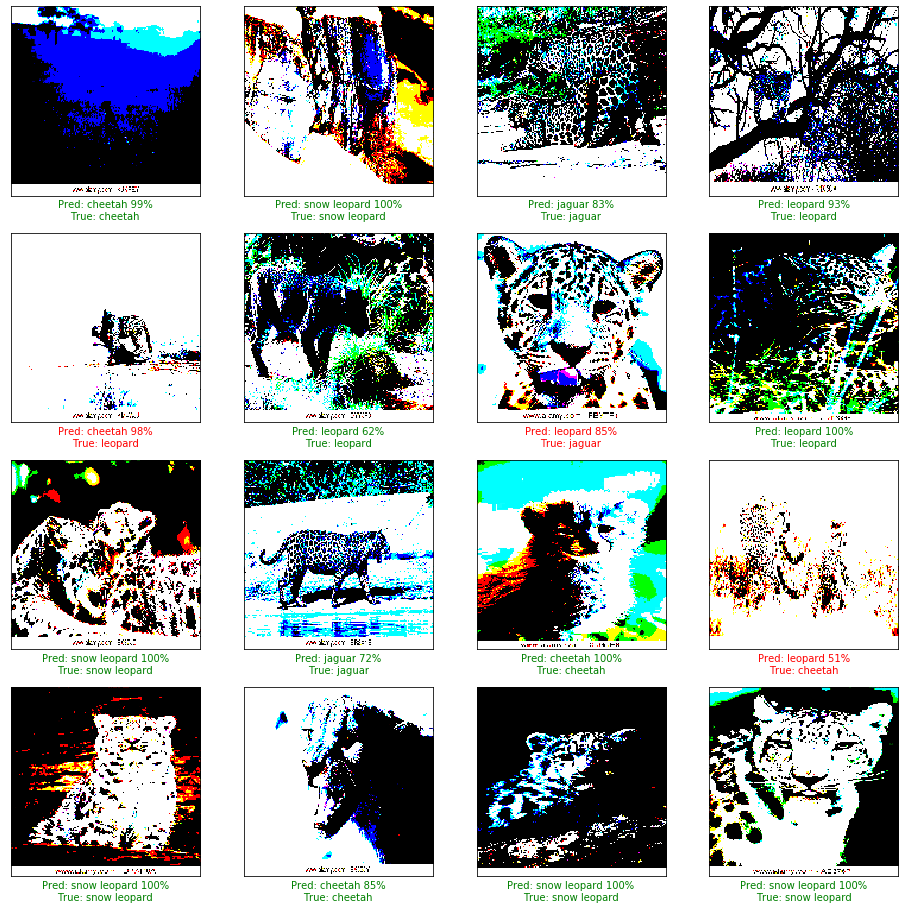

In [41]:
plot_batch(first_preds, first_labels, val_ds[0][0])

It appears the preprocessor utilizes various ways such as recoloring and cropping each image, producing varying levels of definition: some images look much more defined, and others are downright washed out, making it sometimes hard to understand why the model predicted that way.

Some of the misclassified ones:

1. The fifth picture was almost washed out completely, although the proprocessor managed to locate the animal. However, it was too small to detect any meaningful features, so it might have chosen "cheetah" due to having "simple black spots."
2. The seventh picture might have been misclassified due to leopards and jaguars having similar spot designs. Moreover, their heads are often the least distinguishable, having only simple dark spots.
3. The twelfth picture is almost washed out, leaving the spots. Most likely the picture having two animals confused the model to predicting anything besides "cheetah."